In [42]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import hashlib
from Crypto.Cipher import AES
import bz2
import bcrypt
import  base64
import zlib
import pywt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [43]:
def embed_watermark_dwt(coefficients, watermark):
    watermark_length = len(watermark)
    level = 1  # Choose the level of decomposition for DWT

    # Apply DWT to the image
    coeffs = pywt.wavedec2(coefficients, 'haar', level=level)

    # Embed watermark in the LL subband of DWT coefficients
    LL = coeffs[0]
    rows, cols = LL.shape
    alpha = 0.1  # Scaling factor for watermark embedding

    for i in range(rows):
        for j in range(cols):
            if i * cols + j < watermark_length:
                bit = int(watermark[i * cols + j])
                LL[i, j] = LL[i, j] + alpha * bit

    coeffs_modified = (LL,) + tuple(coeffs[1:])  # Convert list to tuple

    # Reconstruct the image using inverse DWT
    watermarked_img = pywt.waverec2(coeffs_modified, 'haar')

    return watermarked_img.astype(np.uint8)

In [44]:
def extract_watermark_dwt(coefficients, watermark_length):
    level = 1  # Choose the level of decomposition for DWT

    # Separate the modified LL coefficients from the other DWT coefficients
    LL = coefficients[0]

    if len(LL.shape) == 1:
        LL = LL.reshape((1, -1))

    rows, cols = LL.shape
    threshold = 0.1  # Adjust this threshold for watermark extraction
    watermark = ""

    for i in range(rows):
        for j in range(cols):
            if i * cols + j < watermark_length:
                if LL[i, j] > threshold:
                    watermark += "1"
                else:
                    watermark += "0"

    return watermark

In [45]:
def batch_process_dwt(coefficients, watermark_length, batch_size):
    # mse for each block
    block_mses = []
    for i, block in enumerate(coefficients):
        mse = np.mean((block - np.round(block)).flatten() ** 2)
        block_mses.append((i, mse))

    # Sorted according to mse
    sorted_block_positions = [i for i, _ in sorted(block_mses, key=lambda x: x[1])]

    # Apply watermarking to the selected blocks in batches
    for i in range(0, len(sorted_block_positions), batch_size):
        batch_positions = sorted_block_positions[i:i + batch_size]

        for position in batch_positions:
            coefficients[position][0][0] += 1.0 / 256.0

    watermarked_img = pywt.waverec2(coefficients, 'haar')

    watermarked_img = cv2.normalize(watermarked_img, None, 0, 255, cv2.NORM_MINMAX)
    watermarked_img = watermarked_img.astype(np.uint8)

    return watermarked_img

In [46]:
img = cv2.imread('IMG.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

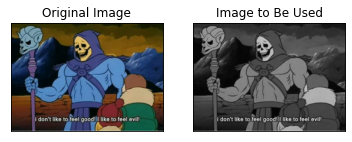

In [47]:
plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB)), plt.title('Image to Be Used')
plt.xticks([]), plt.yticks([])
plt.show()

In [48]:
# Image is divided into smaller blocks
block_size = 8
height, width = gray_img.shape
adjusted_height = height - (height % block_size)
adjusted_width = width - (width % block_size)
gray_img = gray_img[:adjusted_height, :adjusted_width]

blocks = []
for i in range(0, adjusted_height, block_size):
    for j in range(0, adjusted_width, block_size):
        block = gray_img[i:i+block_size, j:j+block_size]
        blocks.append(block)

In [49]:
watermark_data = "1001001 100000 1110111 1100001 1101110 1110100 100000 1110100 1101111 100000 1100111 1101111 100000 1110100 1101111 100000 1001101 1100001 1101100 1110100 1100001"

# zlib + aes
watermark_data_compressed_zlib = zlib.compress(watermark_data.encode())
password = "cse8090ismylastproject"
key = hashlib.sha256(password.encode()).digest()
cipher = AES.new(key, AES.MODE_EAX)
nonce = cipher.nonce
ciphertext_zlib, tag = cipher.encrypt_and_digest(watermark_data_compressed_zlib)

# Compression and Encryption using bz2
watermark_data_compressed_bz2 = bz2.compress(watermark_data.encode())
cipher = AES.new(key, AES.MODE_EAX)
nonce = cipher.nonce
ciphertext_bz2, tag = cipher.encrypt_and_digest(watermark_data_compressed_bz2)


In [50]:
binary_watermark_hashlib = [int(bit) for bit in bin(int.from_bytes(hashlib.md5(watermark_data_compressed_zlib).digest(), byteorder='big'))[2:]]

salt = bcrypt.gensalt()
watermark_data_compressed_bz2_encoded = base64.b64encode(watermark_data_compressed_bz2)
binary_watermark_bcrypt = [int(bit) for bit in bin(int.from_bytes(bcrypt.hashpw(watermark_data_compressed_bz2_encoded, salt), byteorder='big'))[2:]]

In [51]:
binary_watermark = binary_watermark_bcrypt

In [52]:
block_positions = []
for i in range(len(binary_watermark)):
    if binary_watermark[i] == 1:
        block_positions.append(i)

watermarked_blocks = []
for i, block in enumerate(blocks):
    watermarked_block = embed_watermark_dwt(block, binary_watermark)
    watermarked_blocks.append(watermarked_block)

In [53]:
watermark_length = 64
# Reassemble watermarked image
watermarked_img = np.zeros_like(gray_img)
k = 0
for i in range(0, adjusted_height, block_size):
    for j in range(0, adjusted_width, block_size):
        watermarked_img[i:i+block_size, j:j+block_size] = watermarked_blocks[k]
        k += 1
# Batch processing for watermark optimization using DWT
watermarked_img_batch = batch_process_dwt(pywt.wavedec2(watermarked_img, 'haar', level=1), watermark_length, batch_size=16)

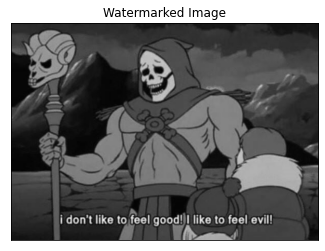

In [54]:
cv2.imwrite("watermarked_image.jpg", watermarked_img)
plt.imshow(cv2.cvtColor(watermarked_img, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.title('Watermarked Image')
plt.show()

In [55]:
def ncc(image1, image2):
    # Normalize images
    norm_image1 = (image1 - np.mean(image1)) / np.std(image1)
    norm_image2 = (image2 - np.mean(image2)) / np.std(image2)

    # Calculate NCC
    ncc_value = np.mean(norm_image1 * norm_image2)

    return ncc_value

psnr_score = psnr(gray_img, watermarked_img, data_range=gray_img.max())
print(f"PSNR value: {psnr_score}")

ssim_value = ssim(gray_img, watermarked_img, data_range=watermarked_img.max() - watermarked_img.min())
print(f"SSIM value: {ssim_value}")

mse = np.mean((gray_img - watermarked_img) ** 2)
print(f"MSE value: {mse}")

ncc_value = ncc(gray_img, watermarked_img)
print(f"NCC value: {ncc_value}")

PSNR value: 75.8577121931171
SSIM value: 0.9999964089948765
MSE value: 0.0016352201257861635
NCC value: 0.999999577159727


In [56]:
# Extract watermark from watermarked image
extracted_watermark = ""
for i, block in enumerate(watermarked_blocks):
    if i in block_positions:
        continue
    extracted_watermark += extract_watermark_dwt(block, 1)  # Extract one bit from each block

watermark_length = 64  # Assuming the watermark length is 64
original_watermark = "I want to go to Malta"  # Replace with the original watermark data used during embedding

# Reverse the compression step
extracted_watermark = zlib.decompress(watermark_data_compressed_zlib).decode()

# Compare the extracted watermark with original watermark data
if extracted_watermark == watermark_data:
    print("Watermark successfully detected.")
else:
    print("Watermark not detected or does not match.")
    
print(extracted_watermark)

Watermark successfully detected.
1001001 100000 1110111 1100001 1101110 1110100 100000 1110100 1101111 100000 1100111 1101111 100000 1110100 1101111 100000 1001101 1100001 1101100 1110100 1100001
